In [1]:
import os
import sys
import pprint
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import ParameterGrid
import pprint
from itertools import chain


base_dir = 'F:\Thesis_ssd\MasterThesis3.0'
os.chdir(base_dir)

from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.DataProcessing.TimeAugmentor import TimeAugmentor
from Classes.DataProcessing.NoiseAugmentor import NoiseAugmentor
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.Modeling.CustomCallback import CustomCallback
from Classes.Modeling.ResultFitter import ResultFitter
from Classes.Modeling.NarrowSearch import NarrowSearch
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter
import json

helper = HelperFunctions()
%load_ext tensorboard

In [2]:
### Data conditions: ###
load_args = {
    'earth_explo_only' : False,
    'noise_earth_only' : False,
    'noise_not_noise' : True,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 0.05,
    'seed' : 1,
    'subsample_size' : 0.05,
    'balance_non_train_set' : True,
    'use_true_test_set' : False
}

loadData = LoadData(**load_args)

full_ds, train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)
dataGen = DataGenerator(loadData)

if load_args['earth_explo_only']:
    full_and_noise_ds = np.concatenate((full_ds, noise_ds))
    timeAug = TimeAugmentor(handler, full_and_noise_ds, seed = load_args['seed'])
else:
    timeAug = TimeAugmentor(handler, full_ds, seed = load_args['seed'])

Mapping redundancy: [-------------------------------->       ] 83 %

In [3]:
############ Model picker #############
model_nr = 7
num_classes = dataGen.num_classes

########### Hyperparameters ###########
batch_size = 64
epochs = 50
learning_rate = 0.01

#opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
activation = 'tanh'
output_layer_activation = 'sigmoid'
dropout_rate = 0.3
filters = 17
kernel_size = 5
l1_r = 0.0001
l2_r = 0.001
padding = 'same'
start_neurons = 32

########### Preprocessing ###########
use_noise_augmentor = True
use_time_augmentor = True
detrend = False
use_scaler = True
use_highpass = False
highpass_freq = 0.2

use_tensorboard = True
use_livelossplot = True
use_custom = False



In [4]:
scaler = None
noiseAug = None
if use_time_augmentor:
    timeAug.fit()
if use_scaler:
    scaler = StandardScalerFitter(train_ds, timeAug).fit_scaler(detrend = detrend)
if use_noise_augmentor:
    noiseAug = NoiseAugmentor(train_ds, use_scaler, scaler, loadData, timeAug)

    
    

gen_args = {
    'batch_size' : batch_size,
    'detrend' : False,
    'use_scaler' : use_scaler,
    'scaler' : scaler,
    'use_time_augmentor' : use_time_augmentor,
    'timeAug' : timeAug,
    'use_noise_augmentor' : use_noise_augmentor,
    'noiseAug' : noiseAug,
    'use_highpass' : use_highpass,
    'highpass_freq' : highpass_freq
}


train_gen = dataGen.data_generator(train_ds, **gen_args)
val_gen = dataGen.data_generator(val_ds, **gen_args)
test_gen = dataGen.data_generator(test_ds, **gen_args)

Fit process completed after 2.3616392612457275 seconds. Total datapoints fitted: 2036.
Average time per datapoint: 0.001159940698057823


In [5]:
X, y = next(train_gen)

In [6]:
X[:][:,[1,2]].shape

(64, 2, 6000)

In [22]:
def transform_event(train_ds, timeAug, noiseAug, scaler, index):
    _, info = handler.path_to_trace(train_ds[index][0])
    trace, label = handler.batch_to_aug_trace(np.array([train_ds[index]]), timeAug)
    trace = handler.transform_batch(scaler, trace)
    trace = noiseAug.batch_augment_noise(trace, 0, noiseAug.noise_std/10)
    print(info['event_type'])
    return trace, info

In [41]:
index = 5
trace, info = transform_event(train_ds, timeAug, noiseAug, scaler, index)

KeyError: 'event_type'

C:\Users\tss_9\anaconda3\lib\site-packages\obspy\imaging\util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
C:\Users\tss_9\anaconda3\lib\site-packages\obspy\imaging\waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


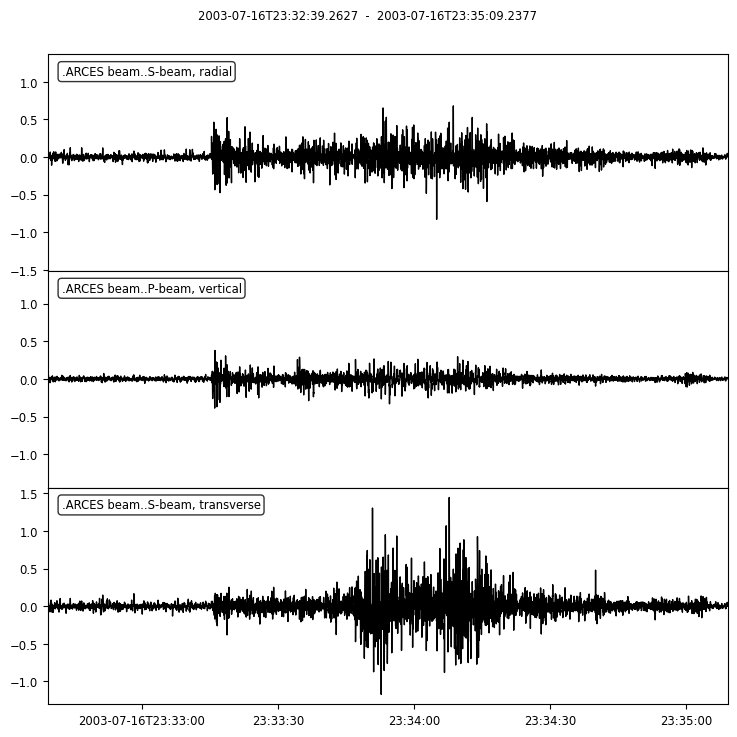

In [42]:
helper.plot_event(trace[0], info)

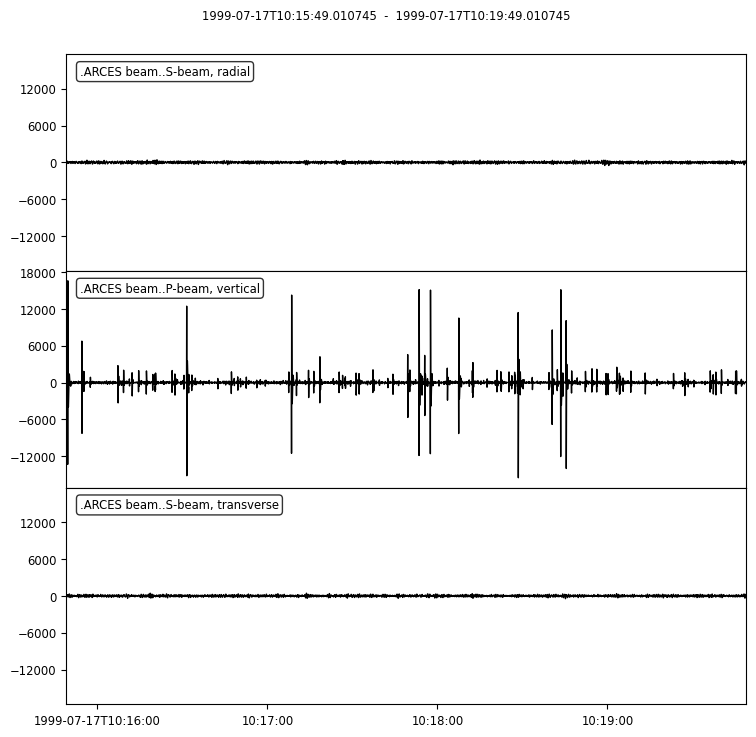

In [43]:
pure_trace, pure_info = handler.path_to_trace(train_ds[index][0])
helper.plot_event(pure_trace, pure_info)

In [44]:
timeAug.fitted_dict[train_ds[index][0]]

{'initial_index': 2399, 'random_start_index': array([132])}